In [ ]:
import csv
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
import matplotlib as plt

In [ ]:
def parse_coordinates_file(file_path ) -> pd.DataFrame:
    coordinates = []
    with open(file_path, "r") as f:
        lines = f.readlines()

    for line in reversed(lines):
        line = line.strip()
        if not line.startswith("0.") and line:
            break

        parts = line.split()
        if len(parts) >= 11:
            row = parts[1:4] + parts[6:10] + [parts[11]]
            if len(row) == 8:
                coordinates.append([float(x) for x in row])

    coordinates_df = pd.DataFrame(coordinates, columns=[
        "rx", "ry", "rz", "px", "py", "pz", "m", "chg"])

    print(f"Parsed {len(coordinates_df)} coordinates from file")
    return coordinates_df


file_path = "bicuskyrm.f14"
coordinates_df = parse_coordinates_file(file_path)
coordinates_df

Parsed 375 coordinates from file


,rx,ry,rz,px,py,pz,m,chg
0,66.139954,-35.237257,62.625780,-0.073242,0.064844,0.138,101.0,-1.0
1,44.576542,21.132161,122.363250,0.051032,0.475605,0.138,101.0,-1.0
2,17.329893,62.270253,123.846110,0.247205,0.446724,0.138,101.0,0.0
3,27.731119,-85.652354,-15.954348,-0.112013,-0.041923,0.138,101.0,-1.0
4,46.628560,42.162045,121.780590,0.191039,0.499985,0.138,101.0,0.0
...,...,...,...,...,...,...,...,...
370,3.089332,46.368581,110.823890,0.502781,1.566314,0.938,1.0,1.0
371,32.246591,47.821696,-38.278148,0.358876,-0.270287,0.938,1.0,1.0
372,-25.411308,-62.091044,69.090274,-0.557321,0.659240,0.938,1.0,1.0
373,-13.992773,-10.790417,105.140570,-0.131222,1.114611,0.938,1.0,0.0


Number of clusters: 43
Number of noise points: 240


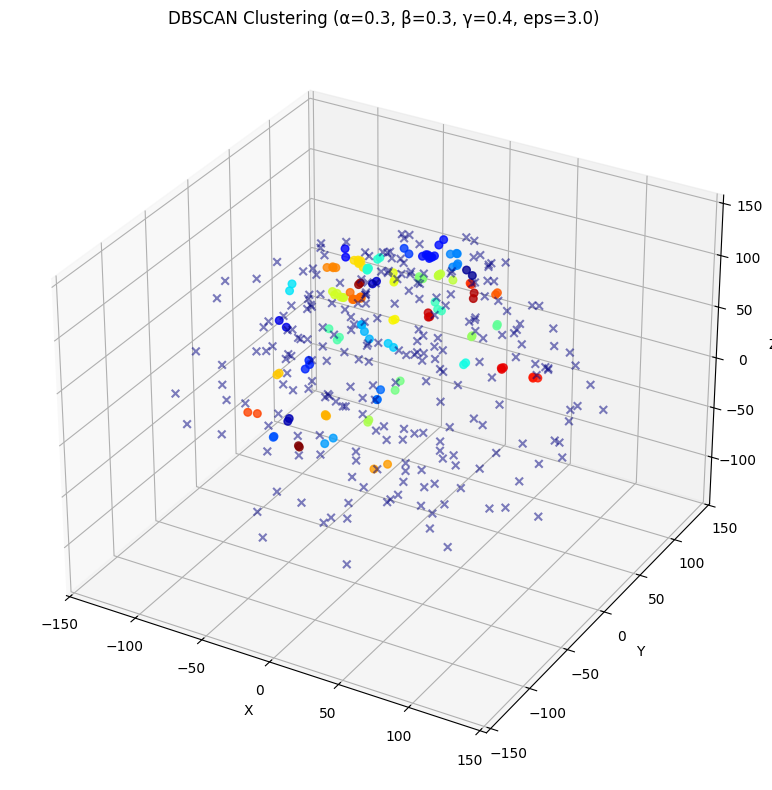

In [ ]:
def custom_distance(X, alpha=0.5, beta=0.5, gamma=0.5):
  n_samples = X.shape[0]
  dist_matrix = np.zeros((n_samples, n_samples))
  
  r_vectors = X[:, 0:3]
  p_vectors = X[:, 3:6]
  charges = X[:, 7]
  
  R_ab = squareform(pdist(r_vectors, 'euclidean'))
  
  p_norms = np.linalg.norm(p_vectors, axis=1)
  p_normalized = np.zeros_like(p_vectors)
  non_zero_mask = p_norms > 0
  p_normalized[non_zero_mask] = p_vectors[non_zero_mask] / p_norms[non_zero_mask, np.newaxis]
  
  cosines = np.zeros((n_samples, n_samples))
  for i in range(n_samples):
    for j in range(i+1, n_samples):
      if p_norms[i] > 0 and p_norms[j] > 0:
        cosines[i, j] = np.dot(p_normalized[i], p_normalized[j])
        cosines[j, i] = cosines[i, j]
      else:
        cosines[i, j] = cosines[j, i] = 1.0
  np.fill_diagonal(cosines, 1.0)
  
  q_product = np.outer(charges, charges)
  

  epsilon = 1e-10
  R_ab_safe = np.maximum(R_ab, epsilon)
  
  dist_matrix = alpha * R_ab + beta * (1.0 - cosines) + gamma * q_product / R_ab_safe
  
  np.fill_diagonal(dist_matrix, 0)
  
  return dist_matrix

X = coordinates_df.to_numpy()

distance_weight = 0.3
angle_weight = 0.3
coulomb_weight = 0.4
eps = 3.0
min_samples = 2

distances = custom_distance(X, alpha=distance_weight, beta=angle_weight, gamma=coulomb_weight)

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
clusters = dbscan.fit_predict(distances)

coordinates_df['cluster'] = clusters

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {list(clusters).count(-1)}")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

unique_clusters = np.unique(clusters)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_clusters)))

for cluster_id, color in zip(unique_clusters, colors):
  cluster_points = coordinates_df[coordinates_df['cluster'] == cluster_id]
  label = 'Noise' if cluster_id == -1 else f'Cluster {cluster_id}'
  marker = 'x' if cluster_id == -1 else 'o'
  alpha = 0.5 if cluster_id == -1 else 0.8
  ax.scatter(
    cluster_points['rx'], 
    cluster_points['ry'], 
    cluster_points['rz'], 
    c=[color], 
    marker=marker,
    label=label,
    s=30,
    alpha=alpha
  )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'DBSCAN Clustering (α={distance_weight}, β={angle_weight}, γ={coulomb_weight}, eps={eps})')
plt.tight_layout()
plt.show()